## Data Cleaning of Air Quality Data and US Population Data
## &
## EDA on the Relationship between Cancer Incidence and Air Quality in the State of California

In [28]:
import pandas as pd
import numpy as np
import os
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from pmdarima import auto_arima

In this notebook we'll be taking a look at cancer incidence rates and the relationship these may have with a set of air quality measures. Our analysis will be limited to the American state of California. Cancer incidence data has been collected at the state level for the years 1999-2019 in several separate .csv files each corresponding to a different type of cancer. Our first order of business is to append these .csv files into a Pandas DataFrame and take a look at the data visually.

In [29]:
# Taking a look at the columns available in each standard cancer incidence rates file
first  = pd.read_csv('./california_cancer_data/statewide_rates/brain_and_nervous.csv')
first.columns

Index(['Area', 'Cancer Type', 'Year', 'Age-Adjusted Rate', 'Case Count',
       'Population'],
      dtype='object')

In [30]:
# Let's use those columns to build our dataframe and make appending easier
cancer_rates = pd.DataFrame(columns=first.columns)

In [31]:
# Looping through available files to create a single dataframe
for record in os.listdir('./california_cancer_data/statewide_rates/'):
    file_df = pd.read_csv('./california_cancer_data/statewide_rates/' + record)
    cancer_rates = pd.concat([cancer_rates, file_df], axis=0)
cancer_rates = cancer_rates.reset_index(drop=True)

In [32]:
## The age-adjusted rate is the number of people per 100,000 who develop a new cancer, controlling
## for age, given older folks have a higher tendency to develop cancer

cancer_rates

,Area,Cancer Type,Year,Age-Adjusted Rate,Case Count,Population
0,California,Oral Cavity and Pharynx,1999,10.8,3192,33499204
1,California,Oral Cavity and Pharynx,2000,10.6,3204,33987977
2,California,Oral Cavity and Pharynx,2001,10.5,3238,34479458
3,California,Oral Cavity and Pharynx,2002,10.3,3250,34871843
4,California,Oral Cavity and Pharynx,2003,10.1,3290,35253159
...,...,...,...,...,...,...
541,California,Brain and Other Nervous System,2015,6.1,2457,38904296
542,California,Brain and Other Nervous System,2016,5.8,2403,39149186
543,California,Brain and Other Nervous System,2017,5.9,2488,39337785
544,California,Brain and Other Nervous System,2018,5.7,2446,39437463


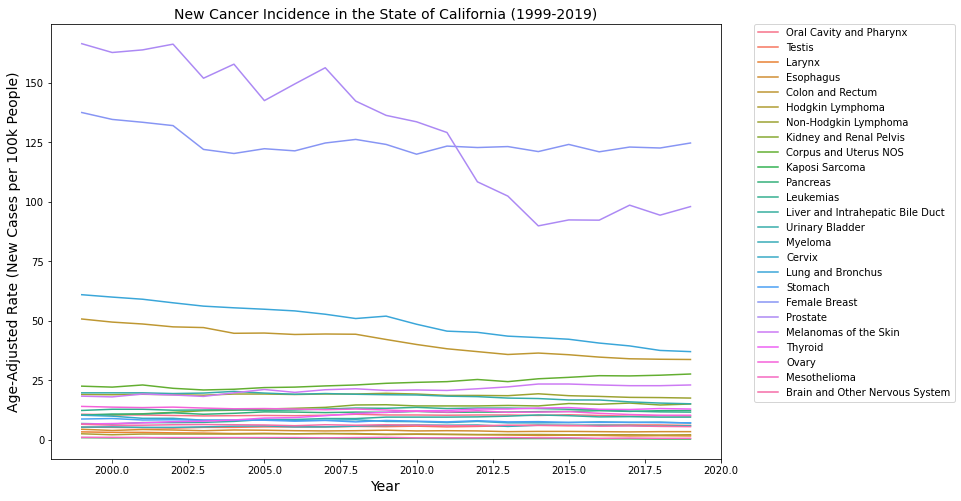

In [33]:
## Lineplot displaying age-adjusted incidence rates (cases per 100,000 people) for each type of cancer
## in the state of California

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=cancer_rates[cancer_rates['Cancer Type'] != 'All Types of Cancer'], 
             x = 'Year', 
             y = 'Age-Adjusted Rate', 
             hue='Cancer Type')

ax.set_title('New Cancer Incidence in the State of California (1999-2019)', fontsize=14)
ax.set_ylabel('Age-Adjusted Rate (New Cases per 100k People)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

While there's **plenty** of cancers listed here, we can see that over the years incidence rates for most of these cancers have held steady, while some have increased/declined gradually over time. Prostate cancer, in particular, has declined precipitously over this 20-year period.

## County-by-County EDA

We have similar data on cancer incidence rates at a county-by-county level, but this data covers 2015-2019 as a single time period. The data was collected by the National Institutes of Health's (NIH) National Cancer Institute, along with the CDC. 

[State Cancer Profiles Incidence Rates Table](https://statecancerprofiles.cancer.gov/incidencerates/index.php?stateFIPS=06&areatype=county&cancer=047&stage=211&race=00&sex=0&age=001&type=incd)



Let's run a script similar to the one above in order to put all of this data, once again presented to us in the form of .csv files, into the same DataFrame.

There's bound to be a few quirks in the data, so we will clean those up as well.

In [34]:
county_rates = pd.DataFrame(columns=['County', ' FIPS',
       'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000',
       'Lower 95% Confidence Interval', 'Upper 95% Confidence Interval',
       'CI*Rank([rank note])', 'Lower CI (CI*Rank)', 'Upper CI (CI*Rank)',
       'Average Annual Count', 'Recent Trend',
       'Recent 5-Year Trend ([trend note]) in Incidence Rates',
       'Lower 95% Confidence Interval.1', 'Upper 95% Confidence Interval.1', 'Cancer'])

for record in os.listdir('./california_cancer_data/county_trends/'):
    if record == '.DS_Store':
        pass
    else:
        cancer_name = record.replace('.csv', '')
        print(cancer_name)
        file_df = pd.read_csv('./california_cancer_data/county_trends/' + record, skiprows=8, nrows=60)
        file_df['Cancer'] = cancer_name
        county_rates = pd.concat([county_rates, file_df], axis=0)
        
county_rates.columns = ['County', 'fips', 'age_adj_incidence_rate', 'l_95_CI', 'u_95_CI', 'CI_Rank', 
                        'l_CI_rank', 'u_CI_rank', 'average_annual_count', 'recent_trend', '5_yr_tr_ir', 
                        'l_95_CI_tr_ir', 'u_95_CI_tr_ir', 'cancer']

county_rates['County'] = county_rates['County'].str.replace(r'[(7)]',"", regex=True)
county_rates['County'] = county_rates['County'].str.replace(' County',"")

county_rates = county_rates[(county_rates['County'] != 'California') & (county_rates['County'] != 'US SEER+NPCR1')]
county_rates = county_rates.reset_index(drop=True)
## Decided to print cancer names so we know what we're dealing with here

oral_cavity_and_pharynx
esophagus
colon_and_rectum
non_hodgkin_lymphoma
brain_and_ons
kidney_and_renal_pelvis
melanoma
pancreas
uterus
breast_female
bladder
liver_and_bile_duct
leukemia
cervix
lung_and_bronchus
stomach
prostate
thyroid
ovary


In [35]:
county_rates.head()

,County,fips,age_adj_incidence_rate,l_95_CI,u_95_CI,CI_Rank,l_CI_rank,u_CI_rank,average_annual_count,recent_trend,5_yr_tr_ir,l_95_CI_tr_ir,u_95_CI_tr_ir,cancer
0,Inyo,6027,18.7,11.7,28.8,1,1,52,5,*,*,*,*,oral_cavity_and_pharynx
1,Colusa,6011,17.2,10.5,26.7,2,1,53,4,*,*,*,*,oral_cavity_and_pharynx
2,Humboldt,6023,16.4,13.7,19.5,3,1,19,28,rising,2.1,0.5,3.7,oral_cavity_and_pharynx
3,Lake,6033,15.4,11.9,19.7,4,1,39,15,stable,2.2,-0.3,4.9,oral_cavity_and_pharynx
4,Tehama,6103,15.2,11.7,19.5,5,1,40,14,stable,2.6,-0.2,5.6,oral_cavity_and_pharynx


In [36]:
# Seems we ahve a bunch of "* " where our incidence rates should be (along with a few other measures)
# If the average_annual_count of a given cancer is 3 or fewer, summary statistics aren't recorded at all.
# How many rows does this represent?
county_rates[county_rates['average_annual_count'] == '3 or fewer'] 

,County,fips,age_adj_incidence_rate,l_95_CI,u_95_CI,CI_Rank,l_CI_rank,u_CI_rank,average_annual_count,recent_trend,5_yr_tr_ir,l_95_CI_tr_ir,u_95_CI_tr_ir,cancer
54,Alpine,6003,*,*,*,*,*,*,3 or fewer,*,*,*,*,oral_cavity_and_pharynx
55,Modoc,6049,*,*,*,*,*,*,3 or fewer,*,*,*,*,oral_cavity_and_pharynx
56,Mono,6051,*,*,*,*,*,*,3 or fewer,*,*,*,*,oral_cavity_and_pharynx
57,Sierra,6091,*,*,*,*,*,*,3 or fewer,*,*,*,*,oral_cavity_and_pharynx
103,Alpine,6003,*,*,*,*,*,*,3 or fewer,*,*,*,*,esophagus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Plumas,6063,*,*,*,*,*,*,3 or fewer,*,*,*,*,ovary
1098,Sierra,6091,*,*,*,*,*,*,3 or fewer,*,*,*,*,ovary
1099,Siskiyou,6093,*,*,*,*,*,*,3 or fewer,*,*,*,*,ovary
1100,Trinity,6105,*,*,*,*,*,*,3 or fewer,*,*,*,*,ovary


In [37]:
# Seems there's 139 rows where we bump into this problem, out of 1102 rows total.
# Given these * results are given due to a miniscule number annual cases (3 or fewer!) let's impute 
# a value of 0 to these entries
county_rates['age_adj_incidence_rate'] = county_rates['age_adj_incidence_rate'].str.replace("* ", "0", regex=False)

In [38]:
# We want to know if incidence rates for cancers over the period 2015-2019 have any relationship to air quality
# We have air-quality data for each county covering this period.

# read in each CSV file in air_quality_data directory and concatenate them into one dataframe
air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])
# filter for only California 
ca_df = air_quality_data.query('State == "California"').copy()

In [39]:
# We can only make comparisons on incidence rates from 2015-2019 so let's filter out the other years.
ca_df_2015_2019 = ca_df[(ca_df['Year'] >= 2015) & (ca_df['Year'] <= 2019)]

In [40]:
# Let's check the results for a single county
ca_df_2015_2019[ca_df_2015_2019['County'] == 'Alameda']

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
50,California,Alameda,2018,365,175,173,5,10,2,0,223,76,51,0,10,72,283,0
52,California,Alameda,2019,365,260,97,8,0,0,0,150,63,41,0,28,175,162,0
50,California,Alameda,2015,365,214,139,12,0,0,0,147,76,46,0,15,180,170,0
49,California,Alameda,2017,365,189,162,9,4,1,0,205,76,49,0,14,110,241,0
49,California,Alameda,2016,366,239,112,13,2,0,0,154,74,44,0,15,214,137,0


In [41]:
ca_df.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10'],
      dtype='object')

In [42]:
# Here's an issue: we have incidence rates for the period covering 2015-2019 but we don't have incidence rates
# by year. Instead what we'll do is average air quality data covering 2015-2019 as a single period, by county,
# and see if air quality measures are useful predictors of cancer incidence

# First we take averages.
ca_2015_2019_avg = ca_df_2015_2019.groupby(by=['County'])[['Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10']].mean()

In [43]:
ca_2015_2019_avg

,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
County,,,,,,,,,,,,,,,
Alameda,365.2,215.4,136.6,9.4,3.2,0.6,0.0,175.8,73.0,46.2,0.0,16.4,150.2,198.6,0.0
Alpine,27.5,11.5,8.0,6.5,1.5,0.0,0.0,117.5,98.0,62.0,0.0,0.0,0.0,27.5,0.0
Amador,362.2,294.8,62.4,5.0,0.0,0.0,0.0,127.0,63.4,39.0,0.0,0.0,362.2,0.0,0.0
Butte,365.2,173.4,172.2,15.2,3.0,0.6,0.8,210.2,87.0,52.2,0.0,0.0,217.6,146.6,1.0
Calaveras,361.8,218.6,127.4,13.4,2.0,0.2,0.2,181.4,81.8,47.0,0.0,0.0,248.6,112.2,1.0
Colusa,365.2,262.8,94.0,4.2,4.0,0.2,0.0,166.4,67.8,42.0,0.0,0.0,201.6,135.0,28.6
Contra Costa,365.2,252.4,103.8,6.0,2.6,0.4,0.0,166.6,66.0,43.6,0.0,3.0,185.2,176.8,0.2
Del Norte,203.4,189.2,13.8,0.0,0.2,0.2,0.0,101.6,44.6,20.0,0.0,0.0,0.0,203.4,0.0
El Dorado,364.6,238.2,98.2,23.4,4.6,0.2,0.0,162.0,94.6,44.4,0.0,0.0,350.0,3.2,11.4


In [44]:
# Now we'll create a new set of columns, each corresponding to a given cancer's incidence rate over 2015-2019
# We'll do this by taking our county-level air quality data, our county-level cancer incidence data, and
# performing an inner join on County

for sickness in county_rates.cancer.unique():
    column_title = sickness + '_ir'
    new_df = county_rates[['County', 'age_adj_incidence_rate']][county_rates['cancer'] == sickness] 
    new_df.columns = ['County', column_title]
    ca_2015_2019_avg = ca_2015_2019_avg.join(new_df.set_index('County'), how='inner')

In [45]:
# However, our incidence rates are still in object type. We want floats.
ca_2015_2019_avg.dtypes

Days with AQI                          float64
Good Days                              float64
Moderate Days                          float64
Unhealthy for Sensitive Groups Days    float64
Unhealthy Days                         float64
Very Unhealthy Days                    float64
Hazardous Days                         float64
Max AQI                                float64
90th Percentile AQI                    float64
Median AQI                             float64
Days CO                                float64
Days NO2                               float64
Days Ozone                             float64
Days PM2.5                             float64
Days PM10                              float64
oral_cavity_and_pharynx_ir              object
esophagus_ir                            object
colon_and_rectum_ir                     object
non_hodgkin_lymphoma_ir                 object
brain_and_ons_ir                        object
kidney_and_renal_pelvis_ir              object
melanoma_ir  

In [46]:
ca_2015_2019_avg = ca_2015_2019_avg.astype(float) # We just turn the whole thing into a dataframe of floats
# County's still the index here so it won't be messed with

In [47]:
ca_2015_2019_avg = ca_2015_2019_avg.reset_index() # We let County be a column again, before we run comparisons
# and regressions

In [48]:
ca_2015_2019_avg.columns = ca_2015_2019_avg.columns.str.replace(" ", "_").str.lower() 
# getting everything into snakecase

In [96]:
ca_2015_2019_avg

,county,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,max_aqi,90th_percentile_aqi,...,breast_female_ir,bladder_ir,liver_and_bile_duct_ir,leukemia_ir,cervix_ir,lung_and_bronchus_ir,stomach_ir,prostate_ir,thyroid_ir,ovary_ir
0,Alameda,365.2,215.4,136.6,9.4,3.2,0.6,0.0,175.8,73.0,...,122.6,14.9,9.8,10.3,5.5,38.6,7.6,92.2,10.9,11.9
1,Alpine,27.5,11.5,8.0,6.5,1.5,0.0,0.0,117.5,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amador,362.2,294.8,62.4,5.0,0.0,0.0,0.0,127.0,63.4,...,135.5,18.2,15.8,14.4,0.0,51.4,5.1,103.0,11.1,0.0
3,Butte,365.2,173.4,172.2,15.2,3.0,0.6,0.8,210.2,87.0,...,129.2,19.9,8.1,15.9,8.3,54.1,6.6,110.2,11.8,11.1
4,Calaveras,361.8,218.6,127.4,13.4,2.0,0.2,0.2,181.4,81.8,...,113.6,24.0,7.0,13.1,0.0,47.0,0.0,95.6,8.1,11.1
5,Colusa,365.2,262.8,94.0,4.2,4.0,0.2,0.0,166.4,67.8,...,113.2,15.3,0.0,0.0,0.0,49.2,0.0,73.2,0.0,0.0
6,Contra Costa,365.2,252.4,103.8,6.0,2.6,0.4,0.0,166.6,66.0,...,133.3,15.8,8.6,11.3,5.2,39.1,6.4,99.8,12.6,9.9
7,Del Norte,203.4,189.2,13.8,0.0,0.2,0.2,0.0,101.6,44.6,...,74.5,16.7,8.3,0.0,0.0,54.0,0.0,75.0,0.0,0.0
8,El Dorado,364.6,238.2,98.2,23.4,4.6,0.2,0.0,162.0,94.6,...,128.2,20.7,6.8,13.5,6.8,37.2,4.3,102.5,14.7,14.1
9,Fresno,365.2,95.4,171.6,78.8,19.0,0.4,0.0,194.8,132.8,...,108.5,14.1,13.1,13.1,8.9,40.9,8.1,86.3,13.2,10.6


Given we have all of this county-level data on air quality along with cancer incidence rate estimates, let's see if we can find a relationship or two that grabs our attention.

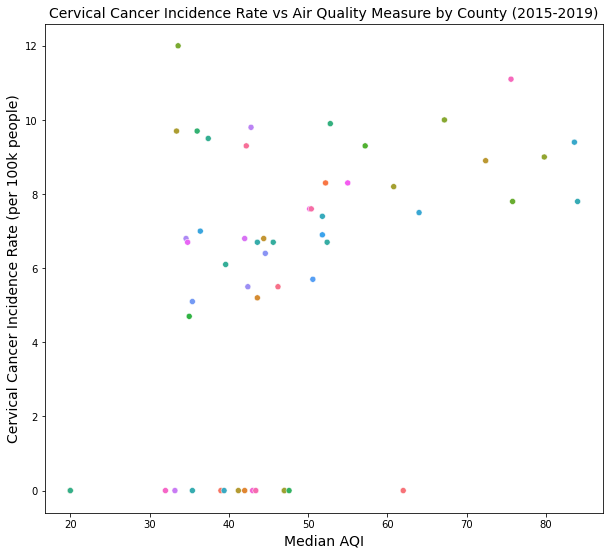

In [98]:
## Here's an example, the incidence rate of cervical cancer vs the median AQI of a given county over the period
## 2015-2019
air_quality_measure = 'median_aqi'
cancer_type = 'cervix_ir'

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(data= ca_2015_2019_avg, 
             x = air_quality_measure, 
             y = cancer_type, 
             hue='county')
plt.title('Cervical Cancer Incidence Rate vs Air Quality Measure by County (2015-2019)', fontsize=14)
plt.xlabel('Median AQI', fontsize=14)
plt.ylabel('Cervical Cancer Incidence Rate (per 100k people)', fontsize=14)
plt.legend([],[], frameon=False) # hiding legend for a sec

plt.show()

It seems that the higher the median AQI (a generic measure of just how polluted the air is), the higher the incidence rate of cervical cancer in a given county. However, this relationship is coarse to the extent that we're averaging median AQI measures across 2015-2019. To better understand this sort of relationship, we might try evaluating more granular time series data.

# Statewide Cancer Incidence Rates and Air Quality

We have year-by-year cancer incidence rate data, but only at the state level.
On the other hand, we have year-by-year air quality data, but only at the county level.

In order to compare apples to apples, we will estimate state-level air quality data by taking county-level air quality data and weighting it by the proportion of the state's population that lives and breathes in that county. For that, we'll use US Census data and its corresponding population estimates by county.

[Source: US Census Data - Population by County (2010-2019)](https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html)

[Source: US Census Data - Population by County (2000-2010)](https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/county/co-est00int-tot.csv)

In [99]:
# Looping through available files to create a single dataframe
for record in os.listdir('./population_data/'):
    print(record)
    
    
 #   file_df = pd.read_csv('./california_cancer_data/statewide_rates/' + record)

# cancer_rates = pd.concat([cancer_rates, file_df], axis=0)
# cancer_rates = cancer_rates.reset_index(drop=True)

co-est00int-tot.csv
co-est2020.csv


In [100]:
census_2010_2020 = pd.read_csv('./population_data/co-est2020.csv')

In [101]:
census_2010_2020.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54970,54747,54922,54903,55302,55448,55533,55769,56130,56145
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,190203,194978,199306,203101,207787,212737,218071,223565,227989,229287
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,27172,26946,26768,26300,25828,25169,24887,24657,24652,24589
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22657,22510,22541,22553,22590,22532,22300,22313,22199,22136


In [102]:
ca_pop_2010_2020 = census_2010_2020[census_2010_2020['STNAME'] == 'California']
ca_pop_2010_2020.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
191,40,4,9,6,0,California,California,37253956,37254522,37319550,...,37944551,38253768,38586706,38904296,39149186,39337785,39437463,39437610,39418894,39368078
192,50,4,9,6,1,California,Alameda County,1510271,1510283,1512997,...,1553729,1579508,1607638,1634326,1650765,1659824,1666596,1668412,1665644,1662323
193,50,4,9,6,3,California,Alpine County,1175,1175,1161,...,1111,1131,1083,1080,1053,1116,1081,1113,1110,1119
194,50,4,9,6,5,California,Amador County,38091,38091,37883,...,37105,36624,36734,37039,37443,38549,39349,39693,40045,40083
195,50,4,9,6,7,California,Butte County,220000,220005,219951,...,220877,221649,223525,224643,226222,228700,230330,218726,214384,212744


In [103]:
## We only need certain columns, and we'd like the population estimates to represent the proportion of the
## state's population that live in a given county

relevant_columns = ['CTYNAME', 'POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 
                   'POPESTIMATE2013', 'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016', 
                    'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019']

pop_estimates = ['POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 
                   'POPESTIMATE2013', 'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016', 
                    'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019']

ca_pop_2010_2020 = ca_pop_2010_2020[relevant_columns]


ca_pop_2010_2020[pop_estimates] = ca_pop_2010_2020[pop_estimates].div(ca_pop_2010_2020[pop_estimates].iloc[0])
ca_pop_2010_2020.head()

,CTYNAME,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019
191,California,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
192,Alameda County,0.040542,0.040676,0.040947,0.041290,0.041663,0.042009,0.042166,0.042194,0.042259,0.042305
193,Alpine County,0.000031,0.000029,0.000029,0.000030,0.000028,0.000028,0.000027,0.000028,0.000027,0.000028
194,Amador County,0.001015,0.000997,0.000978,0.000957,0.000952,0.000952,0.000956,0.000980,0.000998,0.001006
195,Butte County,0.005894,0.005845,0.005821,0.005794,0.005793,0.005774,0.005778,0.005814,0.005840,0.005546


In [104]:
## We now create a new dataframe that lists the proportion of the state's population (WEIGHT)
## that lives in a given county (CTYNAME) by year (YEAR).

county_pop_rates_year = pd.DataFrame(columns=['CTYNAME', 'YEAR', 'WEIGHT'])

for col in pop_estimates:
    yearly_df = pd.DataFrame(columns=['CTYNAME', 'YEAR', 'WEIGHT'])
    yearly_df['CTYNAME'] = ca_pop_2010_2020['CTYNAME']
    yearly_df['YEAR'] = col[-4:]
    yearly_df['WEIGHT'] = ca_pop_2010_2020[col]
    county_pop_rates_year = county_pop_rates_year.append(yearly_df)

In [105]:
county_pop_rates_year[county_pop_rates_year['CTYNAME'] == 'Alameda County']

,CTYNAME,YEAR,WEIGHT
192,Alameda County,2010,0.040542
192,Alameda County,2011,0.040676
192,Alameda County,2012,0.040947
192,Alameda County,2013,0.041290
192,Alameda County,2014,0.041663
192,Alameda County,2015,0.042009
192,Alameda County,2016,0.042166
192,Alameda County,2017,0.042194
192,Alameda County,2018,0.042259
192,Alameda County,2019,0.042305


Seems that worked just fine. Let's run the same set of steps with the previous decade's population data.

In [106]:
census_2000_2010 = pd.read_csv('./population_data/co-est00int-tot.csv')

In [107]:
ca_pop_2000_2010 = census_2000_2010[census_2000_2010['STNAME'] == 'California']
ca_pop_2000_2010.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
190,40,4,9,6,0,California,California,33871653,33987977,34479458,34871843,35253159,35574576,35827943,36021202,36250311,36604337,36961229,37253956,37349363
191,50,4,9,6,1,California,Alameda County,1443705,1449840,1469484,1462106,1454163,1445721,1441545,1444484,1455715,1477208,1498539,1510271,1513952
192,50,4,9,6,3,California,Alpine County,1206,1209,1196,1237,1233,1263,1219,1276,1274,1202,1197,1175,1163
193,50,4,9,6,5,California,Amador County,35101,35153,35697,36561,36994,37400,38040,38353,38756,38248,38238,38091,38042
194,50,4,9,6,7,California,Butte County,203125,203807,206193,209120,211481,213065,214752,216824,217469,219034,219777,220000,220072


In [108]:
relevant_columns = ['CTYNAME', 'POPESTIMATE2000', 'POPESTIMATE2001', 'POPESTIMATE2002', 
                   'POPESTIMATE2003', 'POPESTIMATE2004', 'POPESTIMATE2005', 'POPESTIMATE2006', 
                    'POPESTIMATE2007', 'POPESTIMATE2008', 'POPESTIMATE2009']

pop_estimates = ['POPESTIMATE2000', 'POPESTIMATE2001', 'POPESTIMATE2002', 'POPESTIMATE2003', 
                 'POPESTIMATE2004', 'POPESTIMATE2005', 'POPESTIMATE2006', 'POPESTIMATE2007', 
                 'POPESTIMATE2008', 'POPESTIMATE2009']

ca_pop_2000_2010 = ca_pop_2000_2010[relevant_columns]


ca_pop_2000_2010[pop_estimates] = ca_pop_2000_2010[pop_estimates].div(ca_pop_2000_2010[pop_estimates].iloc[0])
ca_pop_2000_2010.head()

,CTYNAME,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009
190,California,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
191,Alameda County,0.042657,0.042619,0.041928,0.041249,0.040639,0.040235,0.040101,0.040157,0.040356,0.040544
192,Alpine County,0.000036,0.000035,0.000035,0.000035,0.000036,0.000034,0.000035,0.000035,0.000033,0.000032
193,Amador County,0.001034,0.001035,0.001048,0.001049,0.001051,0.001062,0.001065,0.001069,0.001045,0.001035
194,Butte County,0.005996,0.005980,0.005997,0.005999,0.005989,0.005994,0.006019,0.005999,0.005984,0.005946


In [109]:
for col in pop_estimates:
    yearly_df = pd.DataFrame(columns=['CTYNAME', 'YEAR', 'WEIGHT'])
    yearly_df['CTYNAME'] = ca_pop_2000_2010['CTYNAME']
    yearly_df['YEAR'] = col[-4:]
    yearly_df['WEIGHT'] = ca_pop_2000_2010[col]
    county_pop_rates_year = county_pop_rates_year.append(yearly_df)

In [110]:
county_pop_rates_year[county_pop_rates_year['CTYNAME'] == 'Alameda County']

,CTYNAME,YEAR,WEIGHT
192,Alameda County,2010,0.040542
192,Alameda County,2011,0.040676
192,Alameda County,2012,0.040947
192,Alameda County,2013,0.041290
192,Alameda County,2014,0.041663
192,Alameda County,2015,0.042009
192,Alameda County,2016,0.042166
192,Alameda County,2017,0.042194
192,Alameda County,2018,0.042259
192,Alameda County,2019,0.042305


In [111]:
## Our air quality data doesn't have " County" after each county naem so we'll drop it here before we
## join the datasets
county_pop_rates_year['CTYNAME'] = county_pop_rates_year['CTYNAME'].str.replace(" County", "")

In [112]:
## Creating a County_Year column to turn into an index to join on
county_pop_rates_year['County_Year'] = county_pop_rates_year['CTYNAME'] + "_" + county_pop_rates_year['YEAR']

In [113]:
county_pop_rates_year['County_Year']

191    California_2010
192       Alameda_2010
193        Alpine_2010
194        Amador_2010
195         Butte_2010
            ...       
244        Tulare_2009
245      Tuolumne_2009
246       Ventura_2009
247          Yolo_2009
248          Yuba_2009
Name: County_Year, Length: 1180, dtype: object

In [114]:
## Creating a County_Year column to turn into an index to join on
ca_df['County_Year'] = ca_df['County'] + "_" + ca_df['Year'].astype(str)
ca_df['County_Year']

57       Alameda_2009
58        Amador_2009
59         Butte_2009
60     Calaveras_2009
61        Colusa_2009
            ...      
108      Trinity_1999
109       Tulare_1999
110     Tuolumne_1999
111      Ventura_1999
112         Yolo_1999
Name: County_Year, Length: 1285, dtype: object

In [115]:
# Setting indexes to join on
ca_df = ca_df.set_index('County_Year')
county_pop_rates_year = county_pop_rates_year.set_index('County_Year')

In [116]:
## Inner join on both datasets
ts_data = ca_df.join(county_pop_rates_year['WEIGHT'], how='inner')

In [117]:
## Successfully joined for every row. We now have weights to assign our air-quality measures.
ts_data[ts_data['County'] == 'Alameda']

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,WEIGHT
County_Year,,,,,,,,,,,,,,,,,,,
Alameda_2009,California,Alameda,2009,365,190,162,12,1,0,0,151,80,49,0,21,110,234,0,0.040544
Alameda_2008,California,Alameda,2008,366,182,168,12,3,1,0,205,83,51,0,15,100,251,0,0.040356
Alameda_2018,California,Alameda,2018,365,175,173,5,10,2,0,223,76,51,0,10,72,283,0,0.042259
Alameda_2019,California,Alameda,2019,365,260,97,8,0,0,0,150,63,41,0,28,175,162,0,0.042305
Alameda_2014,California,Alameda,2014,365,246,109,10,0,0,0,133,69,43,0,33,155,177,0,0.041663
Alameda_2000,California,Alameda,2000,366,293,59,11,2,1,0,209,70,39,2,129,182,53,0,0.042657
Alameda_2001,California,Alameda,2001,365,290,57,12,6,0,0,178,68,40,1,127,178,59,0,0.042619
Alameda_2015,California,Alameda,2015,365,214,139,12,0,0,0,147,76,46,0,15,180,170,0,0.042009
Alameda_2003,California,Alameda,2003,365,300,53,9,3,0,0,172,64,39,5,105,212,43,0,0.041249


In [118]:
ts_data.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'WEIGHT'],
      dtype='object')

In [119]:
## Applying weights to each air quality measure

air_quality_cols = ['Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10']

for col in air_quality_cols:
    ts_data[col] = ts_data[col] * ts_data['WEIGHT']

In [120]:
ts_data.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,WEIGHT
County_Year,,,,,,,,,,,,,,,,,,,
Alameda_2009,California,Alameda,2009,14.798391,7.703272,6.568053,0.486522,0.040544,0.0,0.0,6.122074,3.243483,1.986633,0.0,0.851414,4.459789,9.487188,0.0,0.040544
Amador_2009,California,Amador,2009,0.374505,0.308294,0.065176,0.001035,0.000000,0.0,0.0,0.126214,0.069314,0.039313,0.0,0.000000,0.374505,0.000000,0.0,0.001035
Butte_2009,California,Butte,2009,2.170345,1.100038,0.880030,0.184331,0.005946,0.0,0.0,0.927599,0.594615,0.297307,0.0,0.005946,1.563837,0.600561,0.0,0.005946
Calaveras_2009,California,Calaveras,2009,0.452030,0.329088,0.084445,0.038497,0.000000,0.0,0.0,0.168890,0.115491,0.050916,0.0,0.000000,0.438370,0.013660,0.0,0.001242
Colusa_2009,California,Colusa,2009,0.209848,0.138557,0.071291,0.000000,0.000000,0.0,0.0,0.055768,0.037945,0.025297,0.0,0.000000,0.109236,0.100612,0.0,0.000575


In [121]:
## No longer need the index we constructed, given the datasets we were working with originally have been joined
ts_data = ts_data.reset_index(drop=True)

In [122]:
## Dropping County and WEIGHT so that we can sum weighted air quality data measures to get state-level air
## quality measures. 

ts_data_grouped = ts_data.drop(columns=['County', 'WEIGHT']).reset_index(drop=True)

In [123]:
# Carrying otu the sum
ts_data_grouped = ts_data_grouped.groupby(['State', 'Year']).sum().reset_index()

In [124]:
ts_data_grouped # We now have State-level air quality data for the years 2000-2019

,State,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,California,2000,363.279000,129.055405,131.614307,64.641692,32.701192,5.252650,0.013755,213.935666,129.726187,71.790986,3.729155,74.436846,176.911835,104.686231,3.514932
1,California,2001,363.108767,122.007743,133.737795,70.297569,30.293275,6.704133,0.068252,227.469711,129.558179,73.906145,1.522703,61.481326,183.976552,112.115517,4.012669
2,California,2002,362.754063,117.551178,139.338293,62.877890,32.526242,10.341602,0.118859,217.847770,136.188933,73.859586,1.829375,53.054626,191.024213,112.908444,3.937405
3,California,2003,362.199118,126.832960,134.928487,55.057050,31.569969,13.794660,0.015992,225.947488,141.438401,70.992024,1.218672,49.909312,208.105724,100.438645,2.526765
4,California,2004,363.168394,118.875883,151.102750,58.618596,31.092621,3.464969,0.013575,190.541881,128.566860,69.288373,0.222068,37.277011,202.737644,120.853557,2.078114
5,California,2005,362.141515,139.107761,143.854123,48.450783,24.802778,5.916873,0.009198,190.433754,124.253067,63.766147,0.755770,43.117100,201.729518,114.748454,1.790673
6,California,2006,362.416462,135.514205,145.972046,50.103190,25.532541,5.286328,0.008152,204.776039,127.327100,64.619253,0.483553,42.829247,204.813283,109.723257,4.567121
7,California,2007,363.150734,132.683402,150.412779,56.098786,20.686754,3.126106,0.142908,261.727118,118.047724,65.449975,0.258408,42.816456,199.041421,115.114365,5.920084
8,California,2008,364.119675,113.889657,170.233441,49.460938,25.037538,5.435434,0.062667,206.433504,129.909488,68.230898,0.114490,40.145839,190.682920,127.375387,5.801039
9,California,2009,363.101127,124.162040,168.503740,45.118771,23.579071,1.730582,0.006923,190.860056,119.621862,63.681746,0.077228,23.556331,195.402311,137.470173,6.595085


In [125]:
## Setting index to Year, so that we may join the cancer rates data on Year as well
ts_data_grouped = ts_data_grouped.set_index('Year')

In [126]:
cancer_rates['Cancer Type'].unique()

array(['Oral Cavity and Pharynx', 'Testis', 'Larynx', 'Esophagus',
       'Colon and Rectum', 'Hodgkin Lymphoma', 'Non-Hodgkin Lymphoma',
       'Kidney and Renal Pelvis', 'All Types of Cancer',
       'Corpus and Uterus NOS', 'Kaposi Sarcoma', 'Pancreas', 'Leukemias',
       'Liver and Intrahepatic Bile Duct', 'Urinary Bladder', 'Myeloma',
       'Cervix', 'Lung and Bronchus', 'Stomach', 'Female Breast',
       'Prostate', 'Melanomas of the Skin', 'Thyroid', 'Ovary',
       'Mesothelioma', 'Brain and Other Nervous System'], dtype=object)

In [127]:
## Getting cancer type data into snakecase so it's easier to read
cancer_rates['Cancer Type'] = cancer_rates['Cancer Type'].str.replace(" ", "_").str.replace("-", "_").str.lower()

In [128]:
cancer_rates['Cancer Type'].unique()

array(['oral_cavity_and_pharynx', 'testis', 'larynx', 'esophagus',
       'colon_and_rectum', 'hodgkin_lymphoma', 'non_hodgkin_lymphoma',
       'kidney_and_renal_pelvis', 'all_types_of_cancer',
       'corpus_and_uterus_nos', 'kaposi_sarcoma', 'pancreas', 'leukemias',
       'liver_and_intrahepatic_bile_duct', 'urinary_bladder', 'myeloma',
       'cervix', 'lung_and_bronchus', 'stomach', 'female_breast',
       'prostate', 'melanomas_of_the_skin', 'thyroid', 'ovary',
       'mesothelioma', 'brain_and_other_nervous_system'], dtype=object)

In [129]:
cancer_rates ## Seems to have worked out just fine

,Area,Cancer Type,Year,Age-Adjusted Rate,Case Count,Population
0,California,oral_cavity_and_pharynx,1999,10.8,3192,33499204
1,California,oral_cavity_and_pharynx,2000,10.6,3204,33987977
2,California,oral_cavity_and_pharynx,2001,10.5,3238,34479458
3,California,oral_cavity_and_pharynx,2002,10.3,3250,34871843
4,California,oral_cavity_and_pharynx,2003,10.1,3290,35253159
...,...,...,...,...,...,...
541,California,brain_and_other_nervous_system,2015,6.1,2457,38904296
542,California,brain_and_other_nervous_system,2016,5.8,2403,39149186
543,California,brain_and_other_nervous_system,2017,5.9,2488,39337785
544,California,brain_and_other_nervous_system,2018,5.7,2446,39437463


In [130]:
## We're going to want to iterate through cancer types to create incidence rate columns we can then join
## to the air quality data.

cancer_types = ['oral_cavity_and_pharynx', 'testis', 'larynx', 'esophagus',
       'colon_and_rectum', 'hodgkin_lymphoma', 'non_hodgkin_lymphoma',
       'kidney_and_renal_pelvis', 'all_types_of_cancer',
       'corpus_and_uterus_nos', 'kaposi_sarcoma', 'pancreas', 'leukemias',
       'liver_and_intrahepatic_bile_duct', 'urinary_bladder', 'myeloma',
       'cervix', 'lung_and_bronchus', 'stomach', 'female_breast',
       'prostate', 'melanomas_of_the_skin', 'thyroid', 'ovary',
       'mesothelioma', 'brain_and_other_nervous_system']

In [131]:
## Looping through cancer types, creating an DataFrame with the appropriate index and column titles, 
## and joining on Year
for cancer in cancer_types:
    new_df = cancer_rates[cancer_rates['Cancer Type'] == cancer][['Year', 'Age-Adjusted Rate']].set_index('Year')
    new_df = new_df.rename(columns={'Age-Adjusted Rate': cancer})
    ts_data_grouped = ts_data_grouped.join(new_df, how='inner')

In [132]:
ts_data_grouped 
## We now have our time series dataset on incidence rates for different types of cancer and air quality data
## for the years 2000-2019

,State,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,...,cervix,lung_and_bronchus,stomach,female_breast,prostate,melanomas_of_the_skin,thyroid,ovary,mesothelioma,brain_and_other_nervous_system
Year,,,,,,,,,,,,,,,,,,,,,
2000,California,363.279000,129.055405,131.614307,64.641692,32.701192,5.252650,0.013755,213.935666,129.726187,...,10.0,60.0,9.0,134.6,162.7,18.1,6.9,13.8,1.1,6.2
2001,California,363.108767,122.007743,133.737795,70.297569,30.293275,6.704133,0.068252,227.469711,129.558179,...,9.1,59.1,8.4,133.4,163.8,19.3,7.2,13.6,1.0,6.2
2002,California,362.754063,117.551178,139.338293,62.877890,32.526242,10.341602,0.118859,217.847770,136.188933,...,9.1,57.6,8.5,132.0,166.2,18.9,7.7,13.8,1.0,6.4
2003,California,362.199118,126.832960,134.928487,55.057050,31.569969,13.794660,0.015992,225.947488,141.438401,...,8.3,56.2,8.3,122.0,151.9,18.3,7.9,13.4,1.0,6.5
2004,California,363.168394,118.875883,151.102750,58.618596,31.092621,3.464969,0.013575,190.541881,128.566860,...,8.2,55.5,8.4,120.3,157.8,19.8,8.4,13.1,1.0,6.4
2005,California,362.141515,139.107761,143.854123,48.450783,24.802778,5.916873,0.009198,190.433754,124.253067,...,8.6,54.9,8.3,122.3,142.5,21.2,9.2,13.2,1.0,6.3
2006,California,362.416462,135.514205,145.972046,50.103190,25.532541,5.286328,0.008152,204.776039,127.327100,...,8.2,54.2,7.9,121.4,149.5,20.0,9.4,13.0,1.0,6.0
2007,California,363.150734,132.683402,150.412779,56.098786,20.686754,3.126106,0.142908,261.727118,118.047724,...,8.3,52.8,8.2,124.7,156.3,21.1,10.2,12.7,0.9,6.4
2008,California,364.119675,113.889657,170.233441,49.460938,25.037538,5.435434,0.062667,206.433504,129.909488,...,8.5,51.0,7.6,126.2,142.3,21.5,11.1,13.0,1.0,6.2


In [133]:
ts_data_grouped.columns = ts_data_grouped.columns.str.replace(" ", "_").str.lower() 

In [140]:
ts_data_grouped

,state,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,max_aqi,90th_percentile_aqi,...,cervix,lung_and_bronchus,stomach,female_breast,prostate,melanomas_of_the_skin,thyroid,ovary,mesothelioma,brain_and_other_nervous_system
Year,,,,,,,,,,,,,,,,,,,,,
2000,California,363.279000,129.055405,131.614307,64.641692,32.701192,5.252650,0.013755,213.935666,129.726187,...,10.0,60.0,9.0,134.6,162.7,18.1,6.9,13.8,1.1,6.2
2001,California,363.108767,122.007743,133.737795,70.297569,30.293275,6.704133,0.068252,227.469711,129.558179,...,9.1,59.1,8.4,133.4,163.8,19.3,7.2,13.6,1.0,6.2
2002,California,362.754063,117.551178,139.338293,62.877890,32.526242,10.341602,0.118859,217.847770,136.188933,...,9.1,57.6,8.5,132.0,166.2,18.9,7.7,13.8,1.0,6.4
2003,California,362.199118,126.832960,134.928487,55.057050,31.569969,13.794660,0.015992,225.947488,141.438401,...,8.3,56.2,8.3,122.0,151.9,18.3,7.9,13.4,1.0,6.5
2004,California,363.168394,118.875883,151.102750,58.618596,31.092621,3.464969,0.013575,190.541881,128.566860,...,8.2,55.5,8.4,120.3,157.8,19.8,8.4,13.1,1.0,6.4
2005,California,362.141515,139.107761,143.854123,48.450783,24.802778,5.916873,0.009198,190.433754,124.253067,...,8.6,54.9,8.3,122.3,142.5,21.2,9.2,13.2,1.0,6.3
2006,California,362.416462,135.514205,145.972046,50.103190,25.532541,5.286328,0.008152,204.776039,127.327100,...,8.2,54.2,7.9,121.4,149.5,20.0,9.4,13.0,1.0,6.0
2007,California,363.150734,132.683402,150.412779,56.098786,20.686754,3.126106,0.142908,261.727118,118.047724,...,8.3,52.8,8.2,124.7,156.3,21.1,10.2,12.7,0.9,6.4
2008,California,364.119675,113.889657,170.233441,49.460938,25.037538,5.435434,0.062667,206.433504,129.909488,...,8.5,51.0,7.6,126.2,142.3,21.5,11.1,13.0,1.0,6.2


No handles with labels found to put in legend.


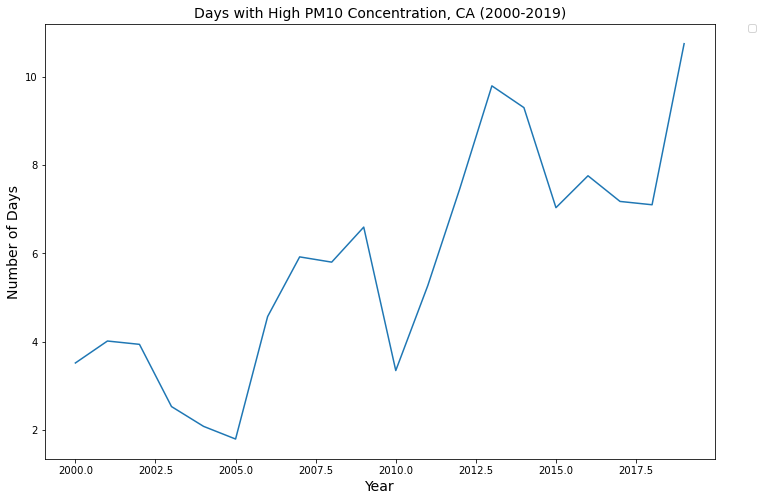

In [149]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ts_data_grouped, 
             x = 'Year', 
             y = 'days_pm10')

ax.set_title('Days with High PM10 Concentration, CA (2000-2019)', fontsize=14)
ax.set_ylabel('Number of Days', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

# ARIMAX Modeling

Here we will try an ARIMAX model, a type of regression model that regresses a given time series on its lagged values, as well as on exogenous variables. 

Our intuition here is that human beings generally don't develop cancer immediately after coming into contact with a carcinogen. In our case, we're intuiting that air quality measures would have a lagged effect on cancer incidence. 

However, we have a lot of air quality measures and cancer incidence rates to look at.

Let's test an ARIMAX model on those air quality measures that capture days with a high concentration of a given kind of particulate and see if they affect the incidence rate of liver & intrahepatic bile duct cancer. See what we find.

In [147]:
arimax_liver = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'liver_and_intrahepatic_bile_duct']]
arimax_liver.shape
arimax_liver.index = pd.to_datetime(arimax_liver.index, format='%Y')
arimax_liver.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [148]:
arimax_liver

,days_co,days_no2,days_ozone,days_pm2.5,days_pm10,liver_and_intrahepatic_bile_duct
Year,,,,,,
2000-01-01,3.729155,74.436846,176.911835,104.686231,3.514932,6.7
2001-01-01,1.522703,61.481326,183.976552,112.115517,4.012669,7.3
2002-01-01,1.829375,53.054626,191.024213,112.908444,3.937405,7.3
2003-01-01,1.218672,49.909312,208.105724,100.438645,2.526765,7.4
2004-01-01,0.222068,37.277011,202.737644,120.853557,2.078114,7.8
2005-01-01,0.755770,43.117100,201.729518,114.748454,1.790673,8.6
2006-01-01,0.483553,42.829247,204.813283,109.723257,4.567121,8.6
2007-01-01,0.258408,42.816456,199.041421,115.114365,5.920084,9.0
2008-01-01,0.114490,40.145839,190.682920,127.375387,5.801039,9.0


We only have 20 years and thus only 20 rows in our dataset. This might yield a weak model, but let's soldier on anyway!

## Determining S

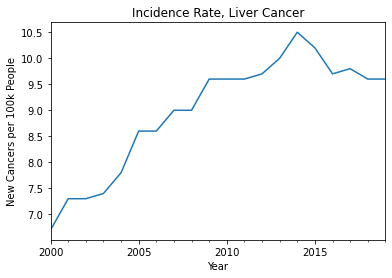

In [149]:
# quick plot of target vs time
arimax_liver['liver_and_intrahepatic_bile_duct'].plot()
plt.ylabel("New Cancers per 100k People")
plt.title("Incidence Rate, Liver Cancer");

## Determine d and D

In [150]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [151]:
# original data (d = 0)
interpret_dftest(arimax_liver['liver_and_intrahepatic_bile_duct'])

Test Statistic    2.297616
p-value           0.998954
dtype: float64

In [152]:
# once differenced data (d = 1)
interpret_dftest(arimax_liver['liver_and_intrahepatic_bile_duct'].diff().dropna())

Test Statistic    0.995046
p-value           0.994213
dtype: float64

In [153]:
# twice differenced data (d = 2)
interpret_dftest(arimax_liver['liver_and_intrahepatic_bile_duct'].diff().diff().dropna())

Test Statistic   -4.828668
p-value           0.000048
dtype: float64

Let's set d=2 and D=2 for now

## Model Preparation

In [154]:
X = arimax_liver.drop(columns=['liver_and_intrahepatic_bile_duct'])
y = arimax_liver['liver_and_intrahepatic_bile_duct']

In [155]:
X.head(2)

,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
Year,,,,,
2000-01-01,3.729155,74.436846,176.911835,104.686231,3.514932
2001-01-01,1.522703,61.481326,183.976552,112.115517,4.012669


## Using auto_arima to determine other components

In [156]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 2, # we know how much to difference, so don't need to waste time searching for this,
    D = 2, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25.809, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.292, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23.911, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.920, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=21.476, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=22.144, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=18.625, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16.764, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=18.516, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.815 seconds


This model gave us an AIC=16.764. However, note that we eyeballed our d and D settings. We only have 20 rows of data. Let's remove these parameters and see what auto_arima selects instead if its forced to find optimal d and D values.

In [157]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25.809, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.292, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23.911, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.920, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=21.476, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=22.144, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=18.625, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16.764, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=18.516, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.642 seconds


In [158]:
# Check orders
print("order: ", sarimax.order)
print("seasonal_order: ", sarimax.seasonal_order)

order:  (0, 2, 1)
seasonal_order:  (0, 0, 0, 0)


In [159]:
y

Year
2000-01-01     6.7
2001-01-01     7.3
2002-01-01     7.3
2003-01-01     7.4
2004-01-01     7.8
2005-01-01     8.6
2006-01-01     8.6
2007-01-01     9.0
2008-01-01     9.0
2009-01-01     9.6
2010-01-01     9.6
2011-01-01     9.6
2012-01-01     9.7
2013-01-01    10.0
2014-01-01    10.5
2015-01-01    10.2
2016-01-01     9.7
2017-01-01     9.8
2018-01-01     9.6
2019-01-01     9.6
Name: liver_and_intrahepatic_bile_duct, dtype: float64

## Modeling

In [160]:
order = (0, 2, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
#    freq = "A", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [161]:
# check summary for issues
print(fitted_air_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:     liver_and_intrahepatic_bile_duct   No. Observations:                   20
Model:                             SARIMAX(0, 2, 1)   Log Likelihood                  -2.016
Date:                              Thu, 19 Jan 2023   AIC                             18.033
Time:                                      18:52:12   BIC                             23.441
Sample:                                  01-01-2000   HQIC                            18.310
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.4311      0.496     -0.869      0.385      -1.403       0.541
days_no2      -0.24

It seems a handful of these coefficients have z-scores that render them not particularly significant at the 95% level. Let's remove them and see what we get.

In [162]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25.809, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.292, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23.911, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.920, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=21.476, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=22.144, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=18.625, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16.764, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=18.516, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.604 seconds


In [163]:
order = (0, 2, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [164]:
y, X

(Year
 2000-01-01     6.7
 2001-01-01     7.3
 2002-01-01     7.3
 2003-01-01     7.4
 2004-01-01     7.8
 2005-01-01     8.6
 2006-01-01     8.6
 2007-01-01     9.0
 2008-01-01     9.0
 2009-01-01     9.6
 2010-01-01     9.6
 2011-01-01     9.6
 2012-01-01     9.7
 2013-01-01    10.0
 2014-01-01    10.5
 2015-01-01    10.2
 2016-01-01     9.7
 2017-01-01     9.8
 2018-01-01     9.6
 2019-01-01     9.6
 Name: liver_and_intrahepatic_bile_duct, dtype: float64,
              days_co   days_no2  days_ozone  days_pm2.5  days_pm10
 Year                                                              
 2000-01-01  3.729155  74.436846  176.911835  104.686231   3.514932
 2001-01-01  1.522703  61.481326  183.976552  112.115517   4.012669
 2002-01-01  1.829375  53.054626  191.024213  112.908444   3.937405
 2003-01-01  1.218672  49.909312  208.105724  100.438645   2.526765
 2004-01-01  0.222068  37.277011  202.737644  120.853557   2.078114
 2005-01-01  0.755770  43.117100  201.729518  114.748454   1.

In [165]:
arimax_liver

,days_co,days_no2,days_ozone,days_pm2.5,days_pm10,liver_and_intrahepatic_bile_duct
Year,,,,,,
2000-01-01,3.729155,74.436846,176.911835,104.686231,3.514932,6.7
2001-01-01,1.522703,61.481326,183.976552,112.115517,4.012669,7.3
2002-01-01,1.829375,53.054626,191.024213,112.908444,3.937405,7.3
2003-01-01,1.218672,49.909312,208.105724,100.438645,2.526765,7.4
2004-01-01,0.222068,37.277011,202.737644,120.853557,2.078114,7.8
2005-01-01,0.755770,43.117100,201.729518,114.748454,1.790673,8.6
2006-01-01,0.483553,42.829247,204.813283,109.723257,4.567121,8.6
2007-01-01,0.258408,42.816456,199.041421,115.114365,5.920084,9.0
2008-01-01,0.114490,40.145839,190.682920,127.375387,5.801039,9.0


In [166]:
# check summary for issues
print(fitted_air_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:     liver_and_intrahepatic_bile_duct   No. Observations:                   20
Model:                             SARIMAX(0, 2, 1)   Log Likelihood                  -2.016
Date:                              Thu, 19 Jan 2023   AIC                             18.033
Time:                                      18:52:18   BIC                             23.441
Sample:                                  01-01-2000   HQIC                            18.310
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.4311      0.496     -0.869      0.385      -1.403       0.541
days_no2      -0.24

## Model Predictions

Some considerations this time:
1. Since we did not conduct a train/test split, we'll need to pick an arbitrary date within the dataset to start forecasting from
1. Since we trained on the entire dataset, the `.predict` method can now properly make "in-sample" predictions, since it has the TRUE values (no need to use multi-step out-of-sample forecasting!).

In [167]:
# starting index: about 80% into dataset
starting_index = round(len(y) * .8)
starting_index

16

In [168]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X) 

In [169]:
air_test_preds

2016-01-01    10.025755
2017-01-01     9.952316
2018-01-01     9.723691
2019-01-01     9.630000
Freq: AS-JAN, Name: predicted_mean, dtype: float64

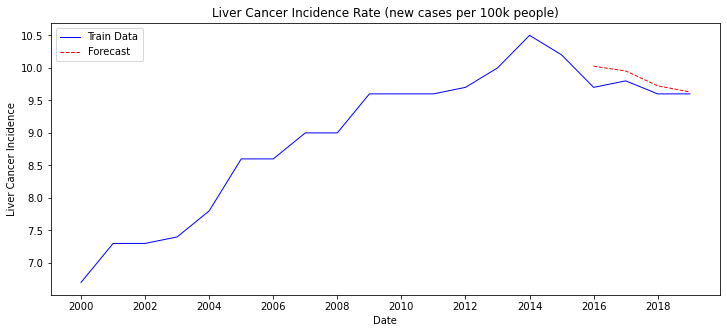

In [170]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Liver Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(air_test_preds.index, air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Liver Cancer Incidence")

# legend
plt.legend(loc = "upper left");

In [171]:
start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

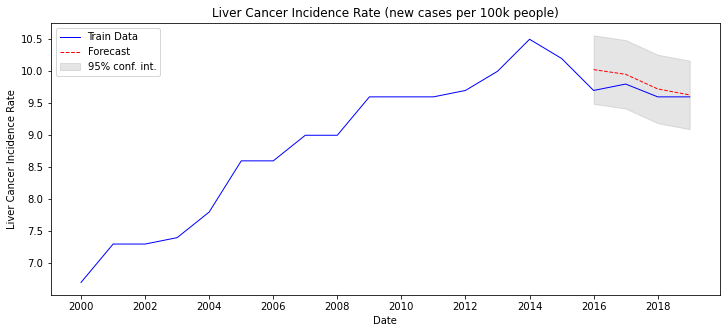

In [172]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Liver Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Liver Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

## Model Scoring

In [174]:
# "Test" score
r2_score(y[start_date:], air_test_preds)


# "Test" score
# r2_score(y[start_date:], air_test_preds)

-4.291505237721128

In [175]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [176]:
mape(y[start_date:], air_test_preds)

1.6283747982337233

On one hand, our R2 score was terrible. The apparent coarseness of our model likely stems from the fact we're working from a dataset with 20 rows. However, our Mean Absolute Percentage Error is 1.63%. It seems our model does a decent job of predicting cancer incidence rates!

Now let's try all of the other cancers in our data set. Let's go through them one by one.

In [179]:
ts_data_grouped.columns

Index(['state', 'days_with_aqi', 'good_days', 'moderate_days',
       'unhealthy_for_sensitive_groups_days', 'unhealthy_days',
       'very_unhealthy_days', 'hazardous_days', 'max_aqi',
       '90th_percentile_aqi', 'median_aqi', 'days_co', 'days_no2',
       'days_ozone', 'days_pm2.5', 'days_pm10', 'oral_cavity_and_pharynx',
       'testis', 'larynx', 'esophagus', 'colon_and_rectum', 'hodgkin_lymphoma',
       'non_hodgkin_lymphoma', 'kidney_and_renal_pelvis',
       'all_types_of_cancer', 'corpus_and_uterus_nos', 'kaposi_sarcoma',
       'pancreas', 'leukemias', 'liver_and_intrahepatic_bile_duct',
       'urinary_bladder', 'myeloma', 'cervix', 'lung_and_bronchus', 'stomach',
       'female_breast', 'prostate', 'melanomas_of_the_skin', 'thyroid',
       'ovary', 'mesothelioma', 'brain_and_other_nervous_system'],
      dtype='object')

In [ ]:
remaining cancers = [
       'testis', 'larynx', 'esophagus', 'colon_and_rectum', 'hodgkin_lymphoma',
       'non_hodgkin_lymphoma', 'kidney_and_renal_pelvis',
       'all_types_of_cancer', 'corpus_and_uterus_nos', 'kaposi_sarcoma',
       'pancreas', 'leukemias', 'liver_and_intrahepatic_bile_duct',
       'urinary_bladder', 'myeloma', 'cervix', 'lung_and_bronchus', 'stomach',
       'female_breast', 'prostate', 'melanomas_of_the_skin', 'thyroid',
       'ovary', 'mesothelioma', 'brain_and_other_nervous_system']]

In [187]:
arimax_ocp = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 
                                'oral_cavity_and_pharynx']]

arimax_ocp.index = pd.to_datetime(arimax_ocp.index, format='%Y')

X = arimax_ocp.drop(columns=['oral_cavity_and_pharynx'])
y = arimax_ocp['oral_cavity_and_pharynx']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=152.302, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5.608, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6.230, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4.693, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6.991, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4.502, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5.173, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6.553, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3.033, Time=0.06 sec

Best model:  AR

In [188]:
#OCP 

order = (0, 0, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [189]:
# check summary for issues
print(fitted_air_sarimax.summary())

                                  SARIMAX Results                                  
Dep. Variable:     oral_cavity_and_pharynx   No. Observations:                   20
Model:                    SARIMAX(0, 0, 1)   Log Likelihood                   8.741
Date:                     Thu, 19 Jan 2023   AIC                             -7.482
Time:                             21:18:00   BIC                             -3.031
Sample:                         01-01-2000   HQIC                            -6.869
                              - 01-01-2019                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0333      0.006      5.776      0.000       0.022       0.045
days_ozone     0.0265      0.002     12.810      0.000       0.022       0.031
days_pm2.5  

In [190]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X) 

In [191]:
start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

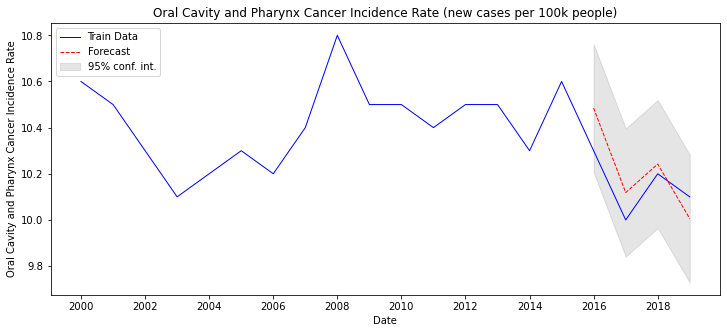

In [192]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Oral Cavity and Pharynx Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Oral Cavity and Pharynx Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [193]:
# "Test" score
r2_score(y[start_date:], air_test_preds)

-0.1761865976067425

In [194]:
mape(y[start_date:], air_test_preds)

1.080908685274002

## Testis

In [199]:
arimax_testis = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'testis']]

arimax_testis.index = pd.to_datetime(arimax_testis.index, format='%Y')

X = arimax_testis.drop(columns=['testis'])
y = arimax_testis['testis']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.894, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.919, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.200 seconds


In [200]:
#Testis 

order = (0, 1, 0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [201]:
# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                 testis   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                   5.472
Date:                Thu, 19 Jan 2023   AIC                              1.056
Time:                        21:31:12   BIC                              6.399
Sample:                    01-01-2000   HQIC                             1.793
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.2056      0.286     -0.719      0.472      -0.766       0.355
days_no2      -0.0302      0.060     -0.502      0.616      -0.148       0.088
days_ozone    -0.0434      0.060     -0.725      0.4

None of these variables seems particularly significant. Let's drop this one!

# Larynx

In [202]:
arimax_larynx = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'larynx']]

arimax_larynx.index = pd.to_datetime(arimax_larynx.index, format='%Y')

X = arimax_larynx.drop(columns=['larynx'])
y = arimax_larynx['larynx']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.791, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.212, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.915, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28.308, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26.945, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-26.798, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-29.253, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-27.001, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-21.198, Time=0.10 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 0.972 seconds


In [203]:
 order = (3, 1, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [204]:
# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                 larynx   No. Observations:                   20
Model:               SARIMAX(3, 1, 1)   Log Likelihood                  16.846
Date:                Thu, 19 Jan 2023   AIC                            -13.692
Time:                        21:33:50   BIC                             -5.966
Sample:                    01-01-2000   HQIC                           -13.296
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co        0.2005      0.255      0.786      0.432      -0.300       0.701
days_no2       0.0276      0.073      0.376      0.707      -0.116       0.171
days_ozone     0.0162      0.084      0.194      0.8

Similarly, a dud!

## Esophagus

In [205]:
arimax_esophagus = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'esophagus']]

arimax_esophagus.index = pd.to_datetime(arimax_esophagus.index, format='%Y')

X = arimax_esophagus.drop(columns=['esophagus'])
y = arimax_esophagus['esophagus']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.350, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4.663, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.004, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.192 seconds


In [207]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:              esophagus   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                   7.357
Date:                Thu, 19 Jan 2023   AIC                             -2.713
Time:                        21:42:12   BIC                              2.629
Sample:                    01-01-2000   HQIC                            -1.977
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.0979      0.202     -0.484      0.629      -0.494       0.299
days_no2       0.0205      0.070      0.292      0.770      -0.117       0.158
days_ozone     0.0237      0.075      0.318      0.7

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Another dud!

# Colon and Rectum

In [209]:
arimax_colon_and_rectum = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'colon_and_rectum']]

arimax_colon_and_rectum.index = pd.to_datetime(arimax_colon_and_rectum.index, format='%Y')

X = arimax_colon_and_rectum.drop(columns=['colon_and_rectum'])
y = arimax_colon_and_rectum['colon_and_rectum']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.908, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.715, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.743, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.959, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=54.706, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.146 seconds


In [210]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:       colon_and_rectum   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -19.812
Date:                Thu, 19 Jan 2023   AIC                             51.623
Time:                        21:43:51   BIC                             56.966
Sample:                    01-01-2000   HQIC                            52.360
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -1.3421      1.162     -1.155      0.248      -3.619       0.935
days_no2      -0.2198      0.360     -0.611      0.541      -0.925       0.486
days_ozone    -0.4021      0.361     -1.114      0.2

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Hodgkin Lymphoma

In [211]:
arimax_hodgkin_lymphoma = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'hodgkin_lymphoma']]

arimax_hodgkin_lymphoma.index = pd.to_datetime(arimax_hodgkin_lymphoma.index, format='%Y')

X = arimax_hodgkin_lymphoma.drop(columns=['hodgkin_lymphoma'])
y = arimax_hodgkin_lymphoma['hodgkin_lymphoma']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.619, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22.277, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.619, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20.353, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.169 seconds


In [218]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                                  SARIMAX Results                                  
Dep. Variable:     oral_cavity_and_pharynx   No. Observations:                   20
Model:                    SARIMAX(0, 1, 0)   Log Likelihood                   5.598
Date:                     Thu, 19 Jan 2023   AIC                             -3.196
Time:                             21:50:10   BIC                              0.365
Sample:                         01-01-2000   HQIC                            -2.705
                              - 01-01-2019                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0360      0.037      0.976      0.329      -0.036       0.108
days_ozone     0.0191      0.033      0.571      0.568      -0.046       0.085
days_pm2.5  

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Non-Hodgkin Lymphoma

In [219]:
arimax_non_hodgkin_lymphoma = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'non_hodgkin_lymphoma']]

arimax_non_hodgkin_lymphoma.index = pd.to_datetime(arimax_non_hodgkin_lymphoma.index, format='%Y')

X = arimax_non_hodgkin_lymphoma.drop(columns=['non_hodgkin_lymphoma'])
y = arimax_non_hodgkin_lymphoma['non_hodgkin_lymphoma']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.208, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.555, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20.360, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.983, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.169 seconds


In [220]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                                SARIMAX Results                                 
Dep. Variable:     non_hodgkin_lymphoma   No. Observations:                   20
Model:                 SARIMAX(0, 1, 0)   Log Likelihood                  -5.474
Date:                  Thu, 19 Jan 2023   AIC                             22.948
Time:                          21:51:05   BIC                             28.290
Sample:                      01-01-2000   HQIC                            23.685
                           - 01-01-2019                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.7218      0.396     -1.823      0.068      -1.498       0.054
days_no2      -0.0997      0.168     -0.595      0.552      -0.428       0.229
days_ozone    -0.1139      0.181    

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Lung and Bronchus

In [214]:
arimax_lung_and_bronchus = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'lung_and_bronchus']]

arimax_lung_and_bronchus.index = pd.to_datetime(arimax_lung_and_bronchus.index, format='%Y')

X = arimax_lung_and_bronchus.drop(columns=['lung_and_bronchus'])
y = arimax_lung_and_bronchus['lung_and_bronchus']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.181, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.015, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=54.880, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.897, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=69.475, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.417 seconds


In [215]:
order = (0,1,1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:      lung_and_bronchus   No. Observations:                   20
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -24.054
Date:                Thu, 19 Jan 2023   AIC                             62.108
Time:                        21:48:27   BIC                             67.940
Sample:                    01-01-2000   HQIC                            62.688
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co        0.0388      2.011      0.019      0.985      -3.903       3.981
days_no2      -0.4174      0.442     -0.944      0.345      -1.284       0.450
days_ozone    -0.2936      0.512     -0.574      0.5

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Kidney and Renal Pelvis

In [221]:
arimax_kidney_and_renal_pelvis = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'kidney_and_renal_pelvis']]

arimax_kidney_and_renal_pelvis.index = pd.to_datetime(arimax_kidney_and_renal_pelvis.index, format='%Y')

X = arimax_kidney_and_renal_pelvis.drop(columns=['kidney_and_renal_pelvis'])
y = arimax_kidney_and_renal_pelvis['kidney_and_renal_pelvis']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.797, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.967, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.005, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.019, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.115 seconds


In [222]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                                  SARIMAX Results                                  
Dep. Variable:     kidney_and_renal_pelvis   No. Observations:                   20
Model:                    SARIMAX(0, 1, 0)   Log Likelihood                 -12.640
Date:                     Thu, 19 Jan 2023   AIC                             37.280
Time:                             21:52:55   BIC                             42.622
Sample:                         01-01-2000   HQIC                            38.017
                              - 01-01-2019                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.0123      0.894     -0.014      0.989      -1.765       1.740
days_no2      -0.1015      0.315     -0.323      0.747      -0.718       0.515
days_ozone  

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Corpus and Uterus Nos

In [223]:
arimax_corpus_and_uterus_nos = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'corpus_and_uterus_nos']]

arimax_corpus_and_uterus_nos.index = pd.to_datetime(arimax_corpus_and_uterus_nos.index, format='%Y')

X = arimax_corpus_and_uterus_nos.drop(columns=['corpus_and_uterus_nos'])
y = arimax_corpus_and_uterus_nos['corpus_and_uterus_nos']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.753, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.513, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=42.478, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42.325, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44.523, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.121 seconds


In [224]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                                 SARIMAX Results                                 
Dep. Variable:     corpus_and_uterus_nos   No. Observations:                   20
Model:                  SARIMAX(0, 1, 0)   Log Likelihood                 -16.412
Date:                   Thu, 19 Jan 2023   AIC                             44.824
Time:                           21:54:01   BIC                             50.166
Sample:                       01-01-2000   HQIC                            45.561
                            - 01-01-2019                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.1505      0.775     -0.194      0.846      -1.670       1.369
days_no2       0.2499      0.328      0.762      0.446      -0.393       0.893
days_ozone     0.2473      0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Kaposi Sarcoma

In [229]:
arimax_kaposi_sarcoma = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'kaposi_sarcoma']]

arimax_kaposi_sarcoma.index = pd.to_datetime(arimax_kaposi_sarcoma.index, format='%Y')

X = arimax_kaposi_sarcoma.drop(columns=['kaposi_sarcoma'])
y = arimax_kaposi_sarcoma['kaposi_sarcoma']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.816, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40.515, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.789, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-43.831, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41.859, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-42.485, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-36.857, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.623 seconds


In [230]:
order = (2,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model
# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:         kaposi_sarcoma   No. Observations:                   20
Model:               SARIMAX(2, 1, 0)   Log Likelihood                  24.909
Date:                Thu, 19 Jan 2023   AIC                            -33.818
Time:                        21:56:01   BIC                            -27.153
Sample:                    01-01-2000   HQIC                           -33.156
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.0070      0.116     -0.061      0.952      -0.234       0.220
days_no2      -0.0233      0.026     -0.893      0.372      -0.074       0.028
days_ozone    -0.0158      0.027     -0.590      0.5

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Pancreas

In [259]:
arimax_pancreas = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'pancreas']]

arimax_pancreas.index = pd.to_datetime(arimax_pancreas.index, format='%Y')

X = arimax_pancreas.drop(columns=['pancreas'])
y = arimax_pancreas['pancreas']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.841, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.010, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.070, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.869, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9.179, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11.957, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.563 seconds


In [260]:
order = (2,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
#fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               pancreas   No. Observations:                   20
Model:               SARIMAX(2, 1, 0)   Log Likelihood                   0.631
Date:                Thu, 19 Jan 2023   AIC                             14.737
Time:                        22:19:54   BIC                             21.403
Sample:                    01-01-2000   HQIC                            15.400
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co        0.7301      0.502      1.453      0.146      -0.254       1.715
days_no2       0.3507      0.141      2.486      0.013       0.074       0.627
days_ozone     0.3700      0.149      2.491      0.0

In [261]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X) 

In [262]:
start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

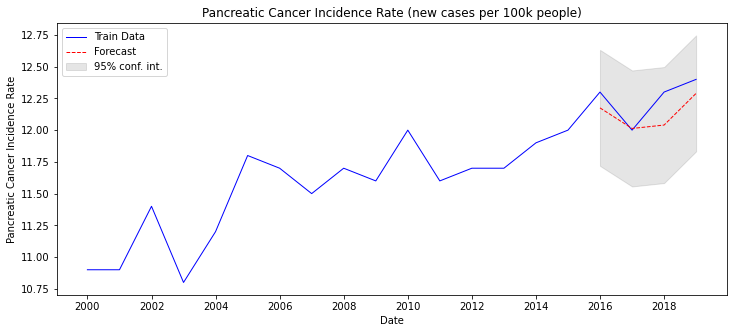

In [263]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Pancreatic Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Pancreatic Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [264]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-0.05999291569270837

In [265]:
mape(y[start_date:], new_air_test_preds)

1.0311139466417607

# Leukemias

In [249]:
arimax_leukemias = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 
                                'leukemias']]

arimax_leukemias.index = pd.to_datetime(arimax_leukemias.index, format='%Y')

X = arimax_leukemias.drop(columns=['leukemias'])
y = arimax_leukemias['leukemias']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.832, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21.986, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=24.002, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22.528, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.793, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16.577, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=25.504, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14.971, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=35.198, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16.257, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18.917, Time=0.13 sec

Best mo

In [251]:
order = (1,0,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:              leukemias   No. Observations:                   20
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  -2.975
Date:                Thu, 19 Jan 2023   AIC                             15.950
Time:                        22:15:32   BIC                             20.672
Sample:                    01-01-2000   HQIC                            16.749
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0411      0.022      1.833      0.067      -0.003       0.085
days_ozone     0.0339      0.006      6.146      0.000       0.023       0.045
days_pm2.5     0.0349      0.005      7.226      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


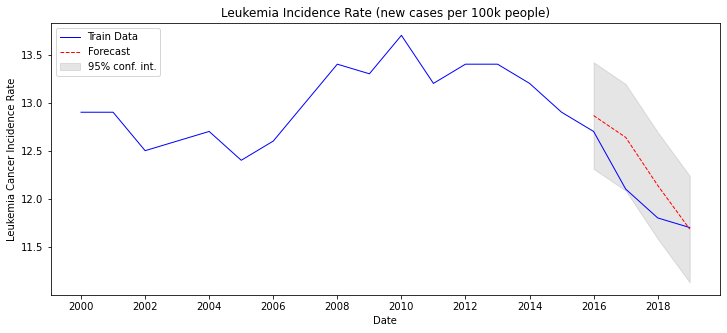

In [252]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Leukemia Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Leukemia Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [256]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

0.2891875927750345

In [266]:
mape(y[start_date:], new_air_test_preds)

1.0311139466417607

# Urinary Bladder

In [270]:
arimax_urinary_bladder = ts_data_grouped[['days_co', 
                                'urinary_bladder']]

arimax_urinary_bladder.index = pd.to_datetime(arimax_urinary_bladder.index, format='%Y')

X = arimax_urinary_bladder.drop(columns=['urinary_bladder'])
y = arimax_urinary_bladder['urinary_bladder']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=33.626, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=30.498, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=31.642, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=24.816, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=21.222, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=21.571, Time=0.03 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0] intercept
Total fit time: 0.413 seconds


In [271]:
order = (3,2,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:        urinary_bladder   No. Observations:                   20
Model:               SARIMAX(3, 2, 0)   Log Likelihood                   1.081
Date:                Thu, 19 Jan 2023   AIC                              7.837
Time:                        22:28:28   BIC                             11.378
Sample:                    01-01-2000   HQIC                             7.800
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.6578      0.157     -4.190      0.000      -0.966      -0.350
ar.L1         -1.0826      0.382     -2.834      0.005      -1.831      -0.334
ar.L2         -0.9435      0.452     -2.088      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


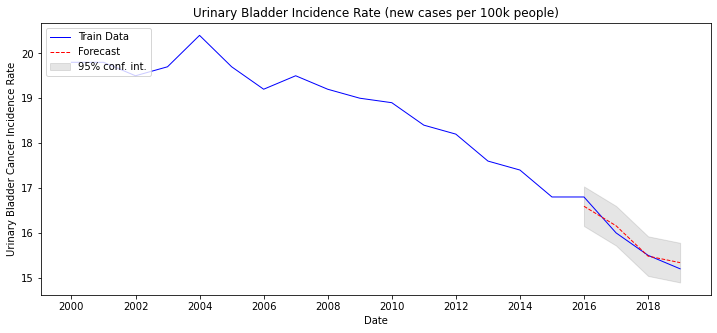

In [272]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Urinary Bladder Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Urinary Bladder Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [273]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

0.9406423212187814

In [274]:
mape(y[start_date:], new_air_test_preds)

0.8106193237532276

## Myeloma

In [275]:
arimax_myeloma = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'myeloma']]

arimax_myeloma.index = pd.to_datetime(arimax_myeloma.index, format='%Y')

X = arimax_myeloma.drop(columns=['myeloma'])
y = arimax_myeloma['myeloma']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7.205, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.776, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5.394, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds


In [276]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                myeloma   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                   7.093
Date:                Thu, 19 Jan 2023   AIC                             -2.186
Time:                        22:47:30   BIC                              3.156
Sample:                    01-01-2000   HQIC                            -1.450
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.0487      0.223     -0.219      0.827      -0.486       0.388
days_no2       0.0449      0.079      0.568      0.570      -0.110       0.200
days_ozone     0.0694      0.082      0.841      0.4

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Cervix

In [298]:
arimax_cervix = ts_data_grouped[['days_no2', 
                                'cervix']]

arimax_cervix.index = pd.to_datetime(arimax_cervix.index, format='%Y')

X = arimax_cervix.drop(columns=['cervix'])
y = arimax_cervix['cervix']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.641, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.646, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.161, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.283, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23.607, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.609, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25.607, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=24.010, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.244 seconds


In [299]:
order = (1,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                 cervix   No. Observations:                   20
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  -1.822
Date:                Thu, 19 Jan 2023   AIC                              9.645
Time:                        23:22:24   BIC                             12.316
Sample:                    01-01-2000   HQIC                            10.013
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0372      0.014      2.581      0.010       0.009       0.066
ar.L1         -0.5559      0.228     -2.438      0.015      -1.003      -0.109
sigma2         0.0717      0.034      2.094      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


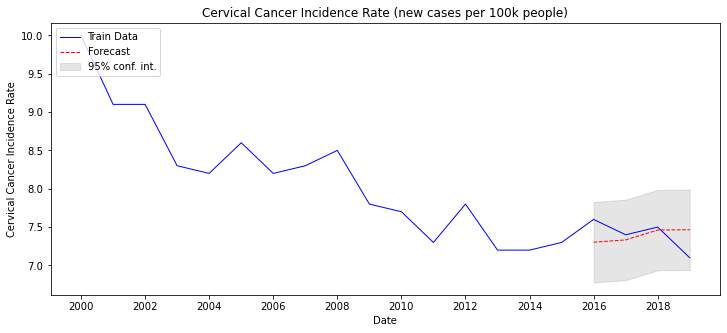

In [302]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Cervical Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Cervical Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [301]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-0.6267805424729378

In [286]:
mape(y[start_date:], new_air_test_preds)

2.618123079323684

# Stomach

In [291]:
arimax_stomach = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'stomach']]

arimax_stomach.index = pd.to_datetime(arimax_stomach.index, format='%Y')

X = arimax_stomach.drop(columns=['stomach'])
y = arimax_stomach['stomach']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.423, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.105, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14.956, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.512, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=0.464, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-0.150, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9.046, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.657 seconds


In [292]:
order = (2,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                stomach   No. Observations:                   20
Model:               SARIMAX(2, 1, 0)   Log Likelihood                   2.878
Date:                Thu, 19 Jan 2023   AIC                             10.244
Time:                        23:07:55   BIC                             16.910
Sample:                    01-01-2000   HQIC                            10.907
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co        0.2387      0.477      0.500      0.617      -0.697       1.174
days_no2      -0.0098      0.077     -0.127      0.899      -0.160       0.140
days_ozone    -0.0111      0.090     -0.123      0.9

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


## Female Breast

In [304]:
arimax_female_breast = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'female_breast']]

arimax_female_breast.index = pd.to_datetime(arimax_female_breast.index, format='%Y')

X = arimax_female_breast.drop(columns=['female_breast'])
y = arimax_female_breast['female_breast']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=251.702, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=116.132, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=117.769, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=118.124, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=119.569, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=109.525, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=111.743, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=107.533, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=117.085, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=109.517, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=114.612, Time=0.10 se

In [305]:
order = (1,0,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:          female_breast   No. Observations:                   20
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -41.178
Date:                Thu, 19 Jan 2023   AIC                             94.355
Time:                        23:23:07   BIC                            100.022
Sample:                    01-01-2000   HQIC                            95.314
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.5928      0.060      9.836      0.000       0.475       0.711
days_ozone     0.2695      0.023     11.804      0.000       0.225       0.314
days_pm2.5     0.3506      0.025     14.057      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


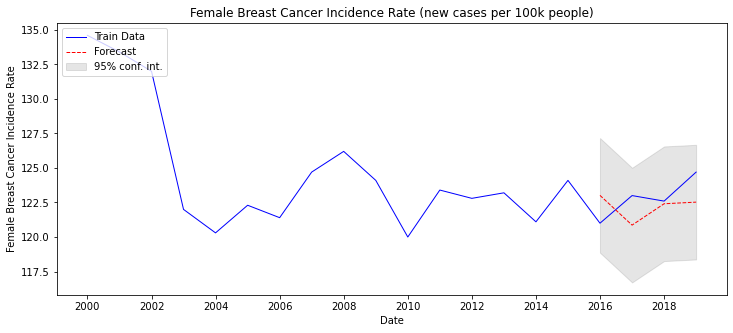

In [306]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Female Breast Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Female Breast Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [307]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-0.933339051246509

In [308]:
mape(y[start_date:], new_air_test_preds)

1.3257526641165835

## Prostate

In [309]:
arimax_prostate = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'prostate']]

arimax_prostate.index = pd.to_datetime(arimax_prostate.index, format='%Y')

X = arimax_prostate.drop(columns=['prostate'])
y = arimax_prostate['prostate']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=138.384, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=139.506, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=139.673, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=139.333, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=141.349, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.098 seconds


In [310]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:               prostate   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -65.245
Date:                Thu, 19 Jan 2023   AIC                            140.489
Time:                        23:25:17   BIC                            144.941
Sample:                    01-01-2000   HQIC                           141.103
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.5979      2.988      0.200      0.841      -5.259       6.455
days_ozone     0.4072      2.559      0.159      0.874      -4.608       5.422
days_pm2.5     0.5259      2.595      0.203      0.8

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


## Melanomas of the Skin

In [313]:
arimax_melanomas_of_the_skin = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'melanomas_of_the_skin']]

arimax_melanomas_of_the_skin.index = pd.to_datetime(arimax_melanomas_of_the_skin.index, format='%Y')

X = arimax_melanomas_of_the_skin.drop(columns=['melanomas_of_the_skin'])
y = arimax_melanomas_of_the_skin['melanomas_of_the_skin']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.399, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.903, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.208 seconds


In [317]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
#fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                                 SARIMAX Results                                 
Dep. Variable:     melanomas_of_the_skin   No. Observations:                   20
Model:                  SARIMAX(0, 1, 0)   Log Likelihood                 -20.446
Date:                   Thu, 19 Jan 2023   AIC                             52.892
Time:                           23:27:23   BIC                             58.234
Sample:                       01-01-2000   HQIC                            53.628
                            - 01-01-2019                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.5201      0.942     -0.552      0.581      -2.366       1.326
days_no2       0.0499      0.395      0.126      0.899      -0.724       0.824
days_ozone     0.0144      0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


## Thyroid

In [318]:
arimax_thyroid = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'thyroid']]

arimax_thyroid.index = pd.to_datetime(arimax_thyroid.index, format='%Y')

X = arimax_thyroid.drop(columns=['thyroid'])
y = arimax_thyroid['thyroid']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.928, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.772, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.983, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.257, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.468, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.156 seconds


In [319]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                thyroid   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -11.799
Date:                Thu, 19 Jan 2023   AIC                             35.599
Time:                        23:28:23   BIC                             40.941
Sample:                    01-01-2000   HQIC                            36.335
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.0035      0.635     -0.006      0.996      -1.248       1.241
days_no2       0.0248      0.208      0.119      0.905      -0.382       0.432
days_ozone     0.0526      0.190      0.277      0.7

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


## Ovary

In [330]:
arimax_ovary = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'ovary']]

arimax_ovary.index = pd.to_datetime(arimax_ovary.index, format='%Y')

X = arimax_ovary.drop(columns=['ovary'])
y = arimax_ovary['ovary']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.396, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.212, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.941, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15.448, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17.349, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=23.890, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.572 seconds


In [331]:
order = (2,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  ovary   No. Observations:                   20
Model:               SARIMAX(2, 1, 0)   Log Likelihood                  -5.184
Date:                Thu, 19 Jan 2023   AIC                             26.369
Time:                        23:30:58   BIC                             33.035
Sample:                    01-01-2000   HQIC                            27.031
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co        0.3100      0.642      0.483      0.629      -0.948       1.568
days_no2       0.1698      0.167      1.017      0.309      -0.157       0.497
days_ozone     0.1588      0.200      0.794      0.4

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Mesothelioma

In [343]:
arimax_mesothelioma = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'mesothelioma']]

arimax_mesothelioma.index = pd.to_datetime(arimax_mesothelioma.index, format='%Y')

X = arimax_mesothelioma.drop(columns=['mesothelioma'])
y = arimax_mesothelioma['mesothelioma']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.871, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.961, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38.505, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.844, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36.712, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-34.692, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-36.142, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.383 seconds


In [344]:
order = (0,1,1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:           mesothelioma   No. Observations:                   20
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  19.984
Date:                Thu, 19 Jan 2023   AIC                            -27.968
Time:                        23:36:54   BIC                            -22.969
Sample:                    01-01-2000   HQIC                           -27.471
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2      -0.0489      0.024     -2.014      0.044      -0.097      -0.001
days_ozone    -0.0460      0.023     -2.024      0.043      -0.091      -0.001
days_pm2.5    -0.0457      0.023     -1.984      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


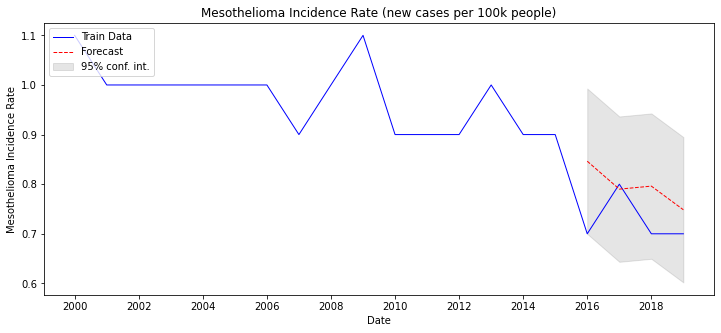

In [345]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Mesothelioma Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Mesothelioma Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [346]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-3.412846368845843

In [348]:
mape(y[start_date:], new_air_test_preds) # Not particularly good!

10.700443672909584

## Brain and Nervous System

In [350]:
arimax_brain_and_other_nervous_system = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'brain_and_other_nervous_system']]

arimax_brain_and_other_nervous_system.index = pd.to_datetime(arimax_brain_and_other_nervous_system.index, format='%Y')

X = arimax_brain_and_other_nervous_system.drop(columns=['brain_and_other_nervous_system'])
y = arimax_brain_and_other_nervous_system['brain_and_other_nervous_system']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.889, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6.869, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.765, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.352, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5.138, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7.639, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.383 seconds


In [351]:
order = (0,1,1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:     brain_and_other_nervous_system   No. Observations:                   20
Model:                           SARIMAX(0, 1, 1)   Log Likelihood                   5.433
Date:                            Thu, 19 Jan 2023   AIC                              1.134
Time:                                    23:39:01   BIC                              6.134
Sample:                                01-01-2000   HQIC                             1.631
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2      -0.0635      0.079     -0.808      0.419      -0.218       0.091
days_ozone    -0.0608      0.077   

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


## All Types of Cancer

In [352]:
arimax_all_types_of_cancer = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'all_types_of_cancer']]

arimax_all_types_of_cancer.index = pd.to_datetime(arimax_all_types_of_cancer.index, format='%Y')

X = arimax_all_types_of_cancer.drop(columns=['all_types_of_cancer'])
y = arimax_all_types_of_cancer['all_types_of_cancer']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.405, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=126.376, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=126.369, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=127.931, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.189 seconds


In [353]:
order = (0,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                                SARIMAX Results                                
Dep. Variable:     all_types_of_cancer   No. Observations:                   20
Model:                SARIMAX(0, 1, 0)   Log Likelihood                 -58.570
Date:                 Thu, 19 Jan 2023   AIC                            127.139
Time:                         23:51:56   BIC                            131.591
Sample:                     01-01-2000   HQIC                           127.753
                          - 01-01-2019                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       1.4611      2.138      0.683      0.494      -2.730       5.652
days_ozone     1.0631      1.849      0.575      0.565      -2.561       4.688
days_pm2.5     1.1295      1.905      0.593 

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
